In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import calendar

In [3]:
# Load the dataset
btc_data = pd.read_csv('BTC-USD.csv')

# Inspection
print(btc_data.info())
print(btc_data.head())

# Check for missing values
print(btc_data.isnull().sum())

# Clean the dataset
btc_data_cleaned = btc_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3504 non-null   object 
 1   Open       3504 non-null   float64
 2   High       3504 non-null   float64
 3   Low        3504 non-null   float64
 4   Close      3504 non-null   float64
 5   Adj Close  3504 non-null   float64
 6   Volume     3504 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 191.8+ KB
None
         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

  

In [4]:
print(btc_data_cleaned.describe())

               Open          High           Low         Close     Adj Close  \
count   3504.000000   3504.000000   3504.000000   3504.000000   3504.000000   
mean   15876.333030  16248.077588  15478.750378  15893.178188  15893.178188   
std    17602.028349  18025.751605  17132.911273  17616.303626  17616.303626   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%     1007.290023   1038.819977    983.123260   1010.719986   1010.719986   
50%     8669.395019   8840.104004   8395.113769   8670.287598   8670.287598   
75%    26754.872070  27135.230957  26360.192871  26768.005860  26768.005860   
max    73079.375000  73750.070313  71334.093750  73083.500000  73083.500000   

             Volume  
count  3.504000e+03  
mean   1.712693e+10  
std    1.929091e+10  
min    5.914570e+06  
25%    2.089795e+08  
50%    1.275815e+10  
75%    2.764960e+10  
max    3.509679e+11  


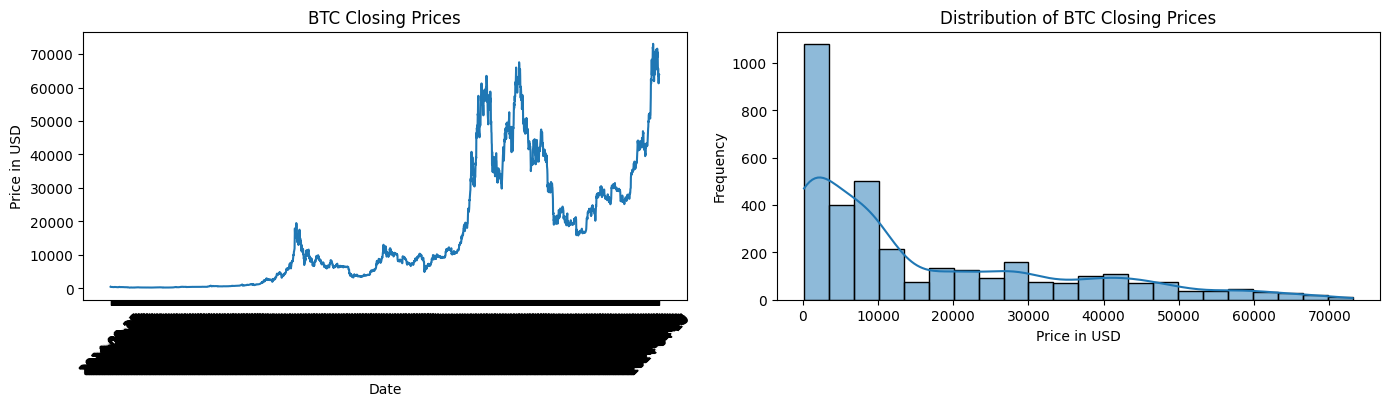

In [5]:
plt.figure(figsize=(14, 7))

# Line plot analysis
plt.subplot(2, 2, 1)
plt.plot(btc_data_cleaned['Date'], btc_data_cleaned['Close'])
plt.title('BTC Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.xticks(rotation=45)

# Histogram for distribution
plt.subplot(2, 2, 2)
sns.histplot(btc_data_cleaned['Close'], kde=True)
plt.title('Distribution of BTC Closing Prices')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


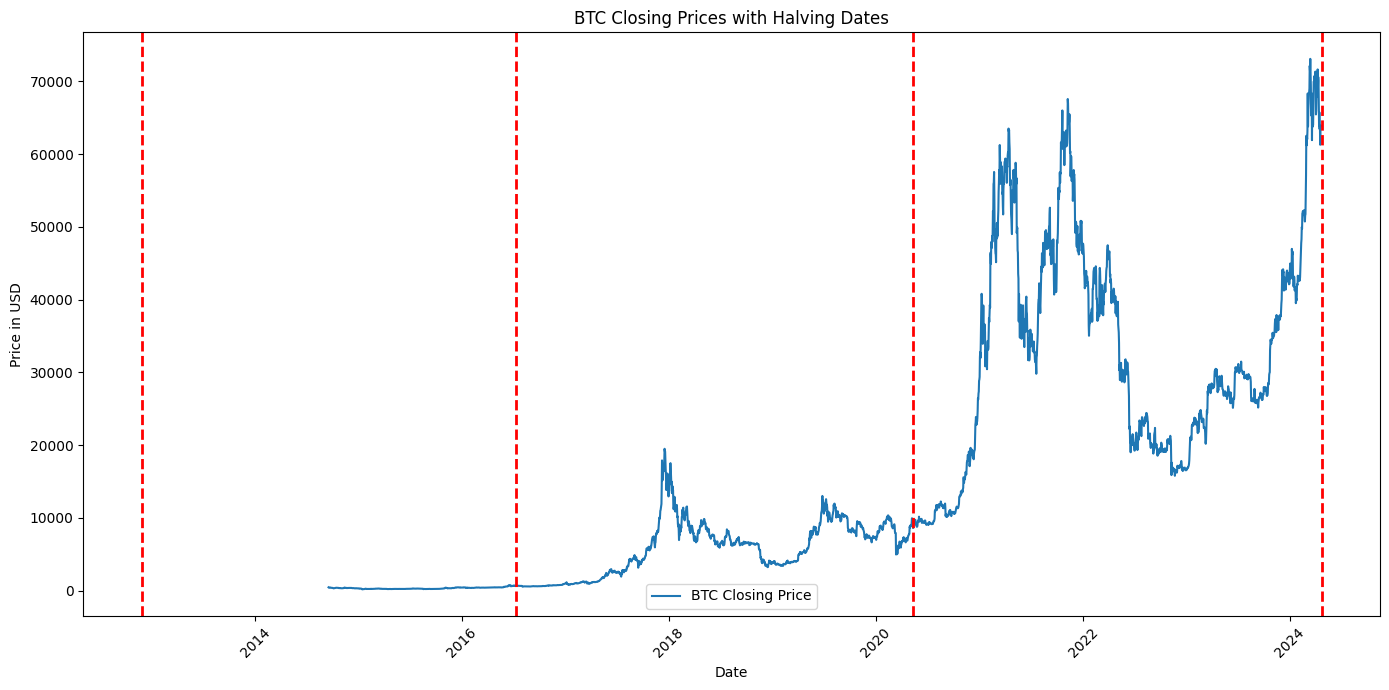

In [6]:
# Convert 'Date' to datetime
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# Plot
plt.figure(figsize=(14, 7))
plt.plot(btc_data['Date'], btc_data['Close'], label='BTC Closing Price')
plt.title('BTC Closing Prices with Halving Dates')
plt.xlabel('Date')
plt.ylabel('Price in USD')

# Add vertical lines for halving dates dates
halving_dates = ['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-22']
for date in halving_dates:
    plt.axvline(pd.Timestamp(date), color='red', linestyle='--', lw=2)

# Rotate date labels
plt.xticks(rotation=45)

plt.tight_layout()
plt.legend()
plt.show()

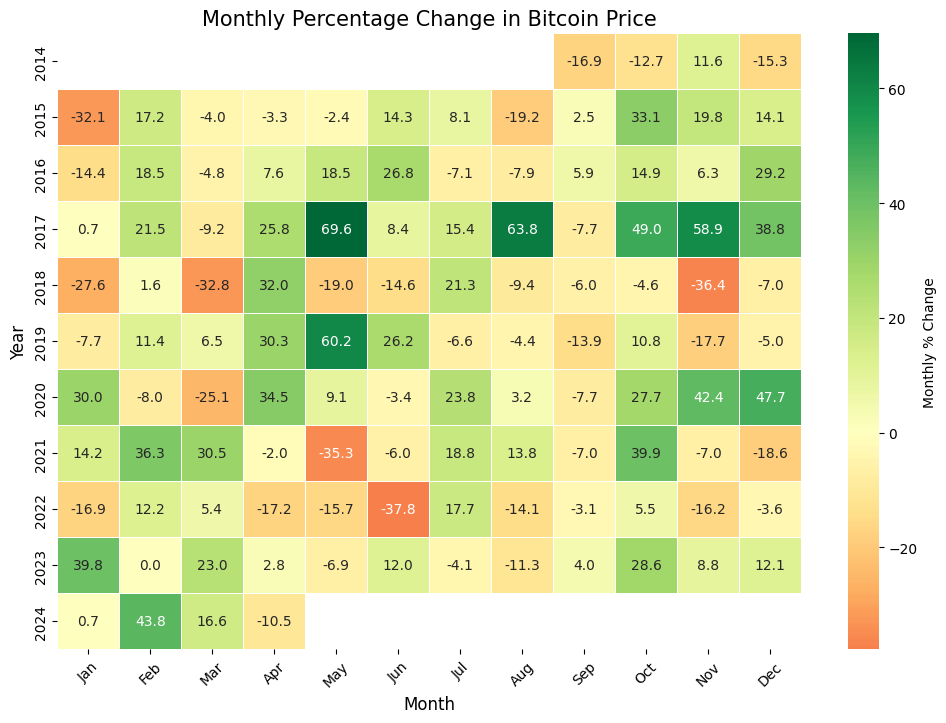

In [24]:
#Creating a heat map for seasonality

# Calculate the percentage change from the first to the last day of each month
btc_data_monthly = btc_data.resample('M').agg({'Open': 'first', 'Close': 'last'})
btc_data_monthly['percent_change'] = ((btc_data_monthly['Close'] - btc_data_monthly['Open']) / btc_data_monthly['Open']) * 100

# Formula to get years on the y-axis and months on the x-axis
pivot_table = btc_data_monthly.pivot_table(index=btc_data_monthly.index.year, columns=btc_data_monthly.index.month, values='percent_change')

pivot_table.columns = [calendar.month_abbr[i] for i in pivot_table.columns]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0, fmt=".1f",
            linewidths=.5, cbar_kws={'label': 'Monthly % Change'})

plt.title('Monthly Percentage Change in Bitcoin Price', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.xticks(rotation=45)

plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette_score is : 0.6072155070201589


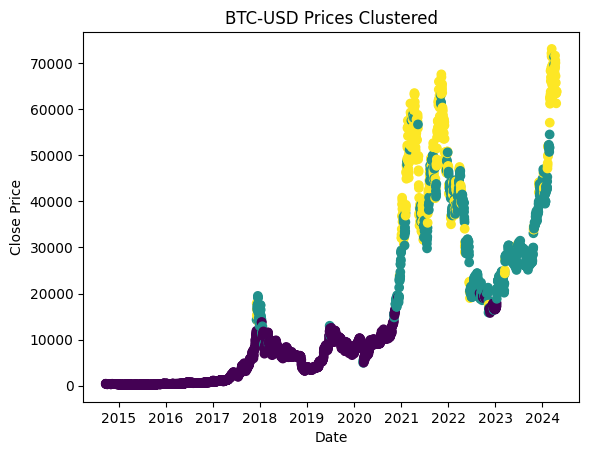

In [12]:
btc_data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])

# Set the Date as the index
btc_data.set_index('Date', inplace=True)

# 7-day moving average and standard deviation
btc_data['7d_avg'] = btc_data['Close'].rolling(window=7).mean()
btc_data['7d_std'] = btc_data['Close'].rolling(window=7).std()

btc_data.dropna(inplace=True)
features = btc_data[['7d_avg', '7d_std']].values

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
btc_data['cluster'] = kmeans.fit_predict(scaled_features)

# silhouette score
silhouette_avg = silhouette_score(scaled_features, btc_data['cluster'])
print(f"The average silhouette_score is : {silhouette_avg}")

plt.scatter(btc_data.index, btc_data['Close'], c=btc_data['cluster'], cmap='viridis')
plt.title("BTC-USD Prices Clustered")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


Estimated number of clusters: 1
Estimated number of noise points: 5


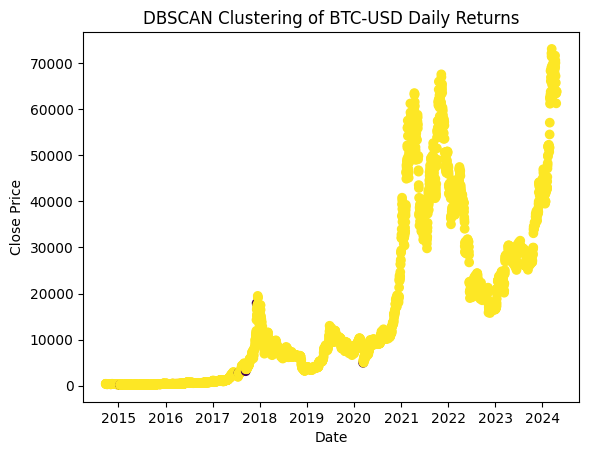

In [13]:
# daily returns
btc_data['Daily_Return'] = btc_data['Close'].pct_change()
btc_data.dropna(inplace=True)

# Reshape the data
X = btc_data['Daily_Return'].values.reshape(-1, 1)

X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

btc_data['Cluster'] = clusters

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

# Plotting the results
import matplotlib.pyplot as plt

plt.scatter(btc_data.index, btc_data['Close'], c=btc_data['Cluster'], cmap='viridis')
plt.title('DBSCAN Clustering of BTC-USD Daily Returns')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


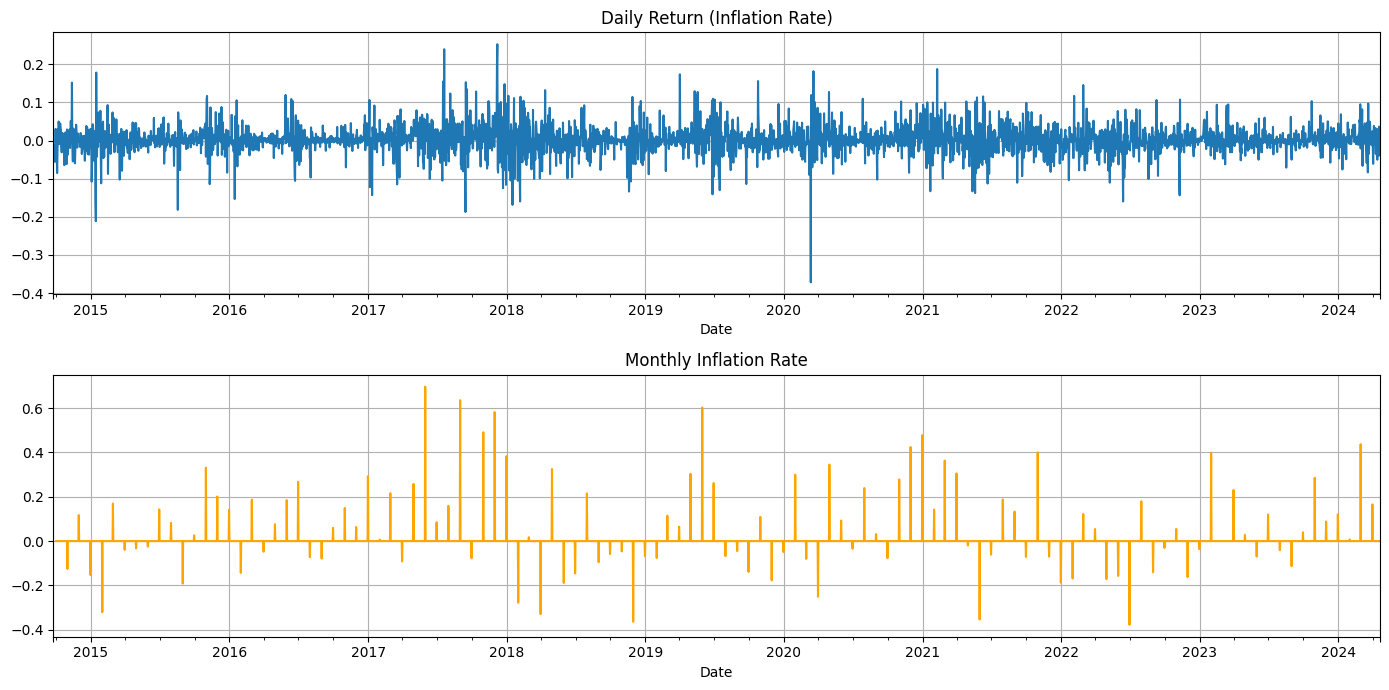

In [14]:
btc_data['Daily_Return'] = btc_data['Close'].pct_change()

btc_data['Monthly_Close'] = btc_data['Close'].resample('M').last()

# Calculate the monthly inflation rate (monthly price change percentage)
btc_data['Monthly_Inflation'] = btc_data['Monthly_Close'].pct_change()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
btc_data['Daily_Return'].plot(title='Daily Return (Inflation Rate)', grid=True)

plt.subplot(2, 1, 2)
btc_data['Monthly_Inflation'].plot(title='Monthly Inflation Rate', color='orange', grid=True)
plt.tight_layout()
plt.show()


In [15]:
btc_data['7d_avg'] = btc_data['Close'].rolling(window=7).mean()
btc_data['7d_std'] = btc_data['Close'].rolling(window=7).std()


btc_data.dropna(inplace=True)
features = btc_data[['7d_avg', '7d_std']].values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# silhouette score
silhouette_avg = silhouette_score(features_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Davies-Bouldin score
davies_bouldin_idx = davies_bouldin_score(features_scaled, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_idx}')


Silhouette Score: 0.60703003023683
Davies-Bouldin Index: 0.7169665766461772


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ADF Statistic: -0.4523712412975416
p-value: 0.9009806357764489


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


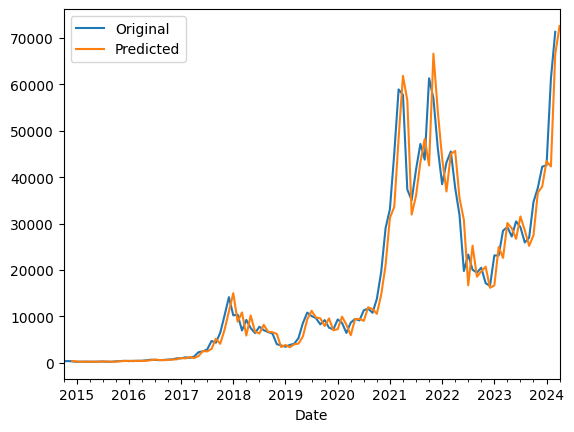

RMSE: 4608.093141254297


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [16]:
btc_prices = btc_data['Close'].dropna()
result = adfuller(btc_prices)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Fit the ARIMA model
model = ARIMA(btc_prices, order=(1, 1, 1))
model_fit = model.fit()

# Plot the actual vs predicted values
btc_prices.plot(label='Original')
model_fit.predict(start=2, end=len(btc_prices), dynamic=False, typ='levels').plot(label='Predicted')
plt.legend()
plt.show()

# Calculate RMSE
predictions = model_fit.predict(start=2, end=len(btc_prices), dynamic=False, typ='levels')
rmse = np.sqrt(((predictions - btc_prices[1:])**2).mean())
print('RMSE:', rmse)

